# UPLOAD DATA

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/kaggle_mais_6/

/content/drive/MyDrive/kaggle_mais_6


In [ ]:
!cp /content/drive/MyDrive/kaggle_mais_6/kaggle.json ~/.kaggle/kaggle.json
!kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset

 95% 153M/161M [00:01<00:00, 107MB/s]
100% 161M/161M [00:01<00:00, 93.4MB/s]


In [ ]:
! unzip corn-or-maize-leaf-disease-dataset.zip

Archive:  corn-or-maize-leaf-disease-dataset.zip
  inflating: data/Blight/Corn_Blight (1).jpeg  
  inflating: data/Blight/Corn_Blight (1).jpg  
  inflating: data/Blight/Corn_Blight (10).jpg  
  inflating: data/Blight/Corn_Blight (100).jpg  
  inflating: data/Blight/Corn_Blight (1000).JPG  
  inflating: data/Blight/Corn_Blight (1001).JPG  
  inflating: data/Blight/Corn_Blight (1002).JPG  
  inflating: data/Blight/Corn_Blight (1003).JPG  
  inflating: data/Blight/Corn_Blight (1004).JPG  
  inflating: data/Blight/Corn_Blight (1005).JPG  
  inflating: data/Blight/Corn_Blight (1006).JPG  
  inflating: data/Blight/Corn_Blight (1007).JPG  
  inflating: data/Blight/Corn_Blight (1008).JPG  
  inflating: data/Blight/Corn_Blight (1009).JPG  
  inflating: data/Blight/Corn_Blight (101).jpg  
  inflating: data/Blight/Corn_Blight (1010).JPG  
  inflating: data/Blight/Corn_Blight (1011).jpg  
  inflating: data/Blight/Corn_Blight (1012).JPG  
  inflating: data/Blight/Corn_Blight (1013).JPG  
  inflatin

# DATA PROCESSING


In [ ]:
#General libraries import
import tensorflow as tf
import keras
import numpy as np
import os.path

In [ ]:
import pandas as pd
#Definition of the function to create the dataframe containing filepaths and labels for the data
def make_dataframe(path):
  filelist = []

  #For loop to iterate into the directories and append the path to the filename
  for dirname, _, filenames in os.walk(path):
      for filename in filenames:
          filelist.append(os.path.join(dirname, filename))
  Filepaths = []
  labels = []
  #each image_file is splitted in label and filepath
  for image_file in filelist:
    label = image_file.split(os.path.sep)[-2]
    Filepaths.append(image_file)
    labels.append(label)

  #Two pandas series are created from filepaths and labels in order to create the dataframe
  Fseries = pd.Series(Filepaths, name="Filepath")
  Lseries = pd.Series(labels, name="Label")
  df = pd.concat([Fseries, Lseries], axis=1)
  df = (df.sample(frac=1, random_state=42).reset_index()).drop(columns="index")
  return df

In [ ]:
#Creation of the dataframe containing all the images
dataset = 'data'
image_df = make_dataframe(dataset)

In [ ]:
image_df

,Filepath,Label
0,data/Common_Rust/Corn_Common_Rust (536).JPG,Common_Rust
1,data/Healthy/Corn_Health (234).jpg,Healthy
2,data/Common_Rust/Corn_Common_Rust (134).JPG,Common_Rust
3,data/Blight/Corn_Blight (635).JPG,Blight
4,data/Healthy/Corn_Health (1083).jpg,Healthy
...,...,...
4183,data/Healthy/Corn_Health (286).jpg,Healthy
4184,data/Blight/Corn_Blight (645).JPG,Blight
4185,data/Healthy/Corn_Health (722).jpg,Healthy
4186,data/Healthy/Corn_Health (147).jpg,Healthy


In [ ]:
from sklearn.model_selection import train_test_split
#Splitting the image_df into training and validation dataframe, shuffling the data and maitaining the ratio between classes
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
#Splitting the image_df into training and validation dataframe, shuffling the data and maitaining the ratio between classes
train_df, val_df = train_test_split(train_df, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
#Visualizing the frequency count of instances in the test dataframe
val_df['Label'].value_counts(normalize=True)

Common_Rust       0.298507
Blight            0.280597
Healthy           0.256716
Gray_Leaf_Spot    0.164179
Name: Label, dtype: float64

In [ ]:
#Visualizing the frequency count of instances in the total training dataframe
train_df['Label'].value_counts(normalize=True)

Common_Rust       0.311940
Healthy           0.282463
Blight            0.279104
Gray_Leaf_Spot    0.126493
Name: Label, dtype: float64

In [ ]:
#Visualizing the frequency count of instances in the test dataframe
test_df['Label'].value_counts(normalize=True)

Common_Rust       0.322196
Healthy           0.278043
Blight            0.250597
Gray_Leaf_Spot    0.149165
Name: Label, dtype: float64

In [ ]:
classes = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
img_size = (224,224)

#Instantiating an ImageDataGenerator class used for training and validation with the augmentation and the preprocessing function
datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
                           rotation_range=10,
                           horizontal_flip='True')
#Instantiating an ImageDataGenerator class used for test with only the preprocessing function
testgen=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

#Calling the method flow_from_dataframe to have a DataFrameIterator containing batch images and labels for each set
train_images = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    classes=classes,
    batch_size=32,
    shuffle=True,
    seed=21
    )

val_images = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    classes=classes,
    batch_size=32,
    shuffle=True,
    seed=21
)

test_images = testgen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    classes=classes,
    batch_size=32,
    shuffle=False
)

Found 2680 validated image filenames belonging to 4 classes.
Found 670 validated image filenames belonging to 4 classes.
Found 838 validated image filenames belonging to 4 classes.


In [ ]:
#We extract a batch of images to visualize them
image, label = next(iter(train_images))

In [ ]:
#Creating a sequential model to rescale images into [0,1] range in order to be visualized
from keras import layers
rescale = tf.keras.Sequential([
  layers.Rescaling(1,offset=+1),
  layers.Rescaling(1./2)
])

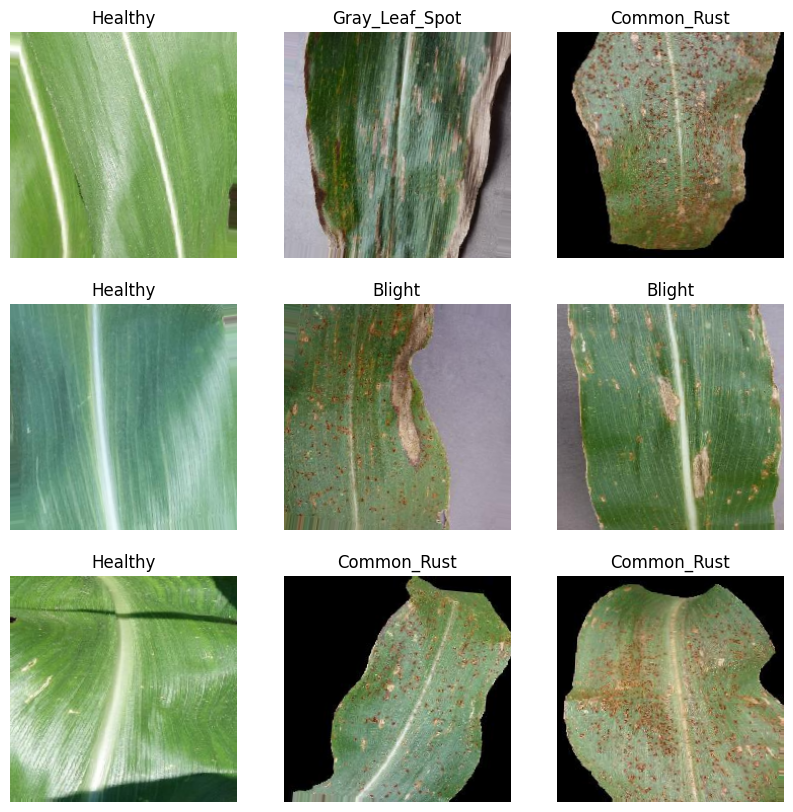

In [ ]:
#Here are going to be displayed 9 images from the batch previously extracted
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(9):
  im = rescale(image[i])
  ax = plt.subplot(3, 3, i + 1)
  ax.set_title(classes[np.argmax(label[i])])
  plt.imshow(im)
  plt.axis("off")

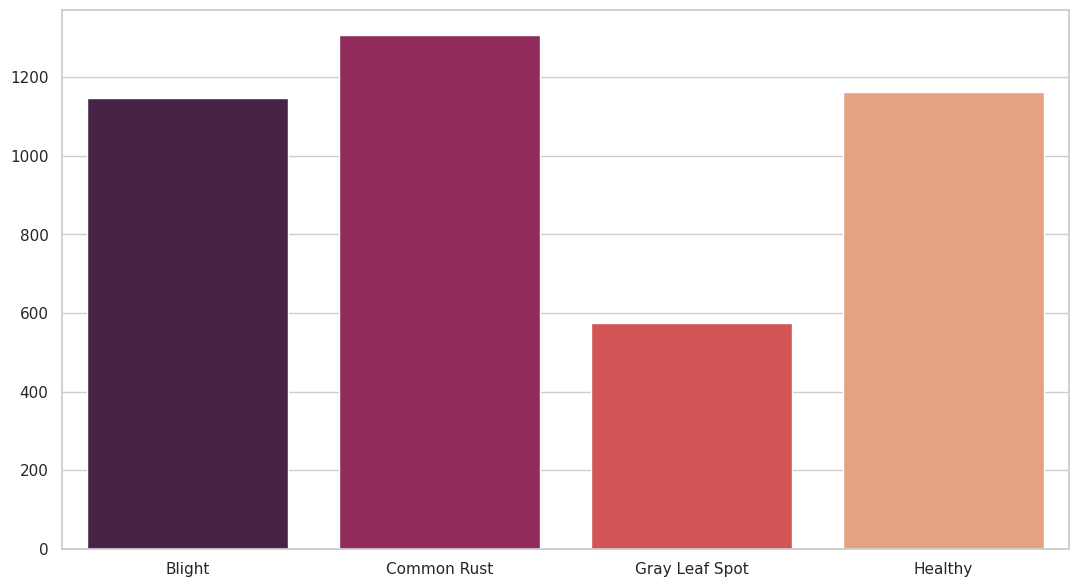

In [ ]:
import seaborn as sns
import glob as gb
sns.set_theme(style="whitegrid")
Data_imbalance = []
for folder in os.listdir(dataset):
    files = gb.glob(pathname=str(dataset + "/" + folder +"/*.*"))
    Data_imbalance.append(len(files))
plt.figure(figsize=(13,7))
sns.barplot(x=["Blight","Common Rust","Gray Leaf Spot","Healthy"], y=Data_imbalance, palette="rocket")
plt.show()

In [ ]:
total = 0
for i in range(0,len(Data_imbalance)) :
    total +=Data_imbalance[i]

weight_for_0 = (1 / Data_imbalance[0]) * (total / 4.0)
weight_for_1 = (1 / Data_imbalance[1]) * (total / 4.0)
weight_for_2 = (1 / Data_imbalance[2]) * (total / 4.0)
weight_for_3 = (1 / Data_imbalance[3]) * (total / 4.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))
print('Weight for class 3: {:.2f}'.format(weight_for_3))

Weight for class 0: 0.91
Weight for class 1: 0.80
Weight for class 2: 1.82
Weight for class 3: 0.90


# MODEL TRAINING

In [ ]:
#Loading the pretrained model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3), #Input shape preferable for MobileNetV2
    include_top=False,  #Not including the densely connected classifier
    weights='imagenet'
)

In [ ]:
#Freezing all the weights of the base convolutional model
base_model.trainable = False

In [ ]:
#Defining a function to build the model from functional API
from keras import layers
def build_model():

  input = layers.Input(shape=(224,224,3))
  x = base_model(input, training=False)
  x = layers.GlobalAveragePooling2D()(x)
  # x = layers.Dense(512, activation='relu')(x)
  #x = layers.Dense(256, activation='relu')(x)
  output = layers.Dense(4, activation='softmax')(x)
  model = keras.Model(inputs=input,outputs=output)
  return model

In [ ]:
model = build_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2263108 (8.63 MB)
Trainable params: 5124 (20.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


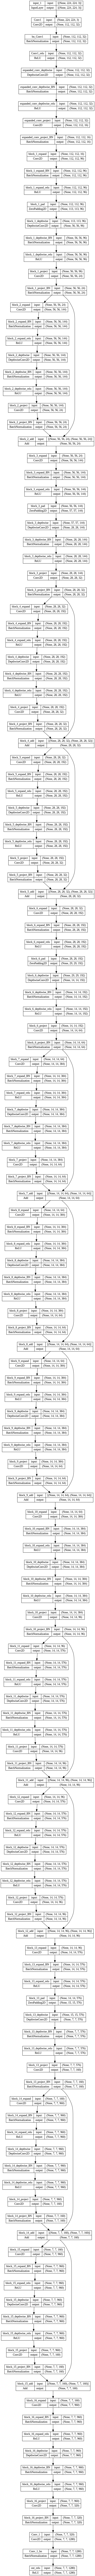

In [ ]:
tf.keras.utils.plot_model(base_model, show_shapes=True)

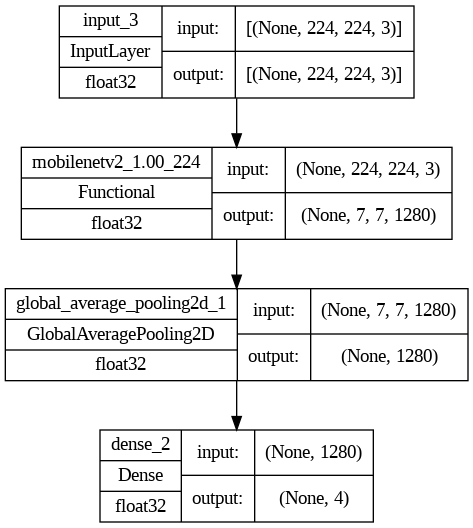

In [ ]:
#Plotting the model
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

In [ ]:
#Callbacks for the model training
from datetime import datetime
name = datetime.now().strftime("corn_%d_%m_%Y_%H_%M_%S.h5")
callbacks = [
    #ModelCheckpoint will save only the best model respect to "val_loss" value into the "name" model
    keras.callbacks.ModelCheckpoint(
        filepath=name,
        verbose=1,
        save_best_only=True,
        monitor="val_loss"),
    # EarlyStopping will stop the training after 5 epochs with no improvement on the "val_loss" value
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        verbose=1,
        mode="auto",
        restore_best_weights=True
    )
]

In [ ]:
from keras.optimizers import Adam
#Compiling the model using binary crossentropy as loss function, Adam as optimizer and using Accuracy, Precision and Recall as metrics
model.compile(
      optimizer = "Adam",
      loss='categorical_crossentropy',
      metrics=['Precision','Recall','accuracy']
      )

In [ ]:
#Training of the model on maximium 20 epochs
history = model.fit(train_images,
                    epochs=15,
                    validation_data=val_images,
                    class_weight=class_weight,
                    callbacks=callbacks
                    )

Epoch 1/15
84/84 [==============================] - ETA: 0s - loss: 0.5439 - precision: 0.8639 - recall: 0.7392 - accuracy: 0.7948
Epoch 1: val_loss improved from inf to 0.35937, saving model to corn_26_09_2023_18_51_59.h5
84/84 [==============================] - 180s 2s/step - loss: 0.5439 - precision: 0.8639 - recall: 0.7392 - accuracy: 0.7948 - val_loss: 0.3594 - val_precision: 0.8810 - val_recall: 0.8284 - val_accuracy: 0.8522
Epoch 2/15
84/84 [==============================] - ETA: 0s - loss: 0.2825 - precision: 0.9163 - recall: 0.8910 - accuracy: 0.9041
Epoch 2: val_loss improved from 0.35937 to 0.24089, saving model to corn_26_09_2023_18_51_59.h5
84/84 [==============================] - 177s 2s/step - loss: 0.2825 - precision: 0.9163 - recall: 0.8910 - accuracy: 0.9041 - val_loss: 0.2409 - val_precision: 0.9209 - val_recall: 0.8866 - val_accuracy: 0.9075
Epoch 3/15
84/84 [==============================] - ETA: 0s - loss: 0.2452 - precision: 0.9254 - recall: 0.9078 - accuracy: 0.

In [ ]:
np.save('history.npy',history.history)

In [ ]:
import numpy as np
history=np.load('/content/drive/MyDrive/kaggle_mais_6/history.npy',allow_pickle='TRUE').item()
#Saving the initial training accuracy and loss on training and validation data
acc = history['accuracy']
val_acc = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

precision = history['precision']
val_precision = history['val_precision']

recall = history['recall']
val_recall = history['val_recall']

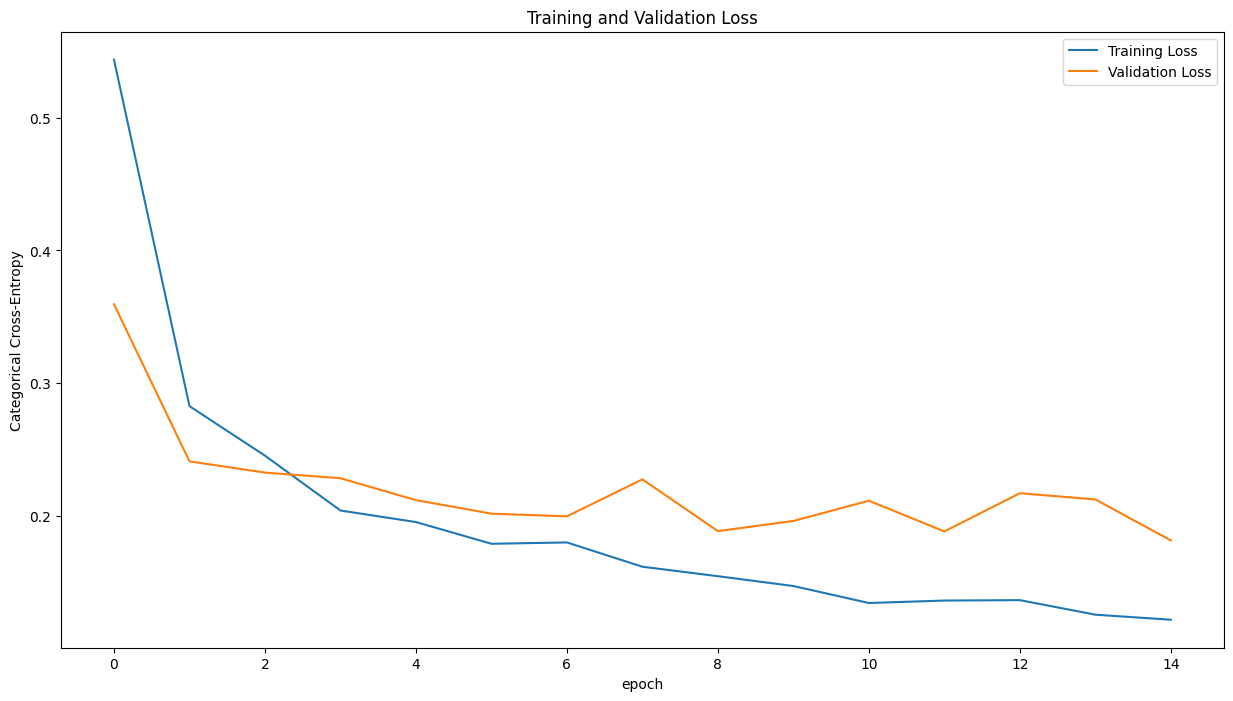

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Categorical Cross-Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# FINE TUNING DEL MODELLO


In [ ]:
#Unfreezing the last 11 layers of the base_model which correspond to the last convolutional block
base_model.trainable = False
base_model.trainable = True
for layer in base_model.layers[:-11]:
  layer.trainable = False

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2263108 (8.63 MB)
Trainable params: 891204 (3.40 MB)
Non-trainable params: 1371904 (5.23 MB)
_________________________________________________________________


In [ ]:
from keras.optimizers import Adam
#Compiling the model for the fine-tuning phase, using the same parameters as the first training but decreasing the learning rate of the optimizer
model.compile(
      optimizer = Adam(learning_rate=1e-8),
      loss='categorical_crossentropy',
      metrics=['Precision','Recall','accuracy']
      )

In [ ]:
#Fine tuning
fthistory = model.fit(train_images,
                    epochs=15+10,
                    initial_epoch=15,
                    validation_data=val_images,
                    class_weight=class_weight,
                    callbacks = callbacks
                    )

Epoch 16/25
84/84 [==============================] - ETA: 0s - loss: 0.1083 - precision: 0.9738 - recall: 0.9698 - accuracy: 0.9728
Epoch 16: val_loss did not improve from 0.18127
84/84 [==============================] - 207s 2s/step - loss: 0.1083 - precision: 0.9738 - recall: 0.9698 - accuracy: 0.9728 - val_loss: 0.2046 - val_precision: 0.9259 - val_recall: 0.9134 - val_accuracy: 0.9209
Epoch 17/25
84/84 [==============================] - ETA: 0s - loss: 0.1133 - precision: 0.9678 - recall: 0.9631 - accuracy: 0.9653
Epoch 17: val_loss did not improve from 0.18127
84/84 [==============================] - 202s 2s/step - loss: 0.1133 - precision: 0.9678 - recall: 0.9631 - accuracy: 0.9653 - val_loss: 0.1921 - val_precision: 0.9348 - val_recall: 0.9209 - val_accuracy: 0.9284
Epoch 18/25
84/84 [==============================] - ETA: 0s - loss: 0.1083 - precision: 0.9707 - recall: 0.9646 - accuracy: 0.9683
Epoch 18: val_loss did not improve from 0.18127
84/84 [=============================

In [ ]:
np.save('fthistory.npy',fthistory.history)

In [ ]:
#Adding the fine-tuning phase values to the initial training
fthistory=np.load('/content/drive/MyDrive/kaggle_mais_6/fthistory.npy',allow_pickle='TRUE').item()
acc += fthistory['accuracy']
val_acc += fthistory['val_accuracy']

loss += fthistory['loss']
val_loss += fthistory['val_loss']

precision += fthistory['precision']
val_precision += fthistory['val_precision']

recall += fthistory['recall']
val_recall += fthistory['val_recall']

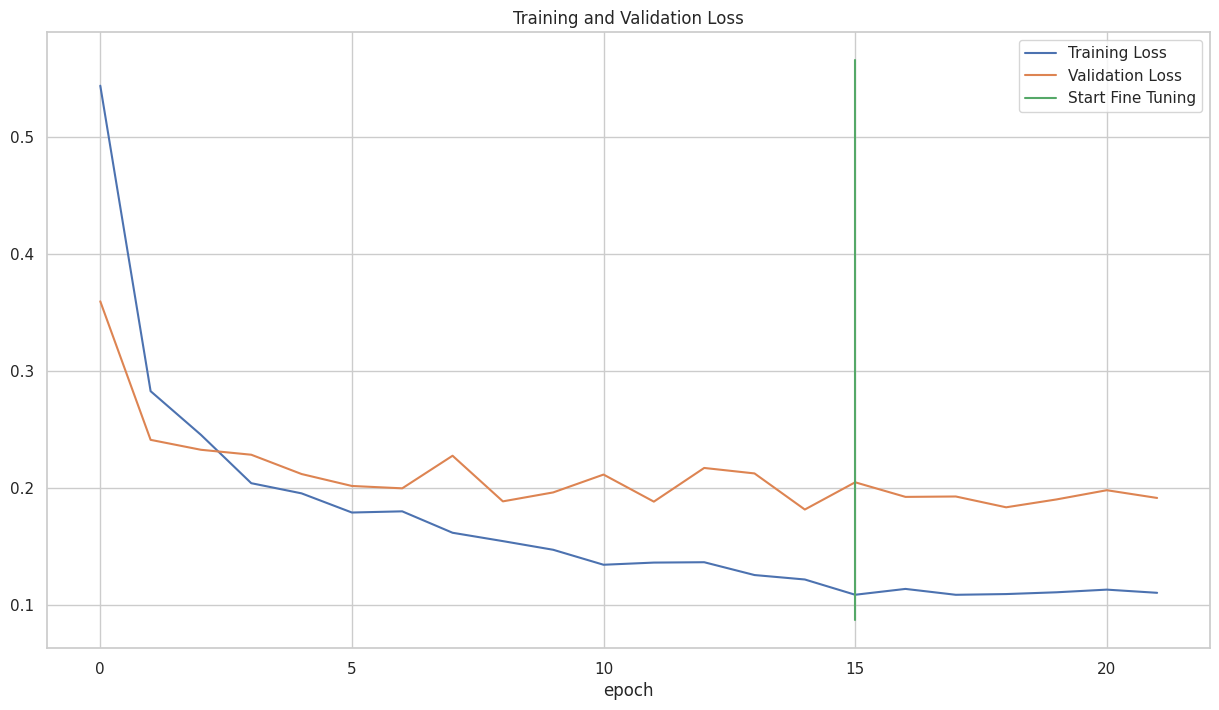

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([15,15],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# METRICS

In [ ]:
from keras.models import load_model
model = load_model("/content/drive/MyDrive/kaggle_mais_6/corn_26_09_2023_18_51_59.h5")

In [ ]:
model.evaluate(test_images)
#Prediction of the model on the test set
preds= model.predict(test_images)
#iterating all the predictions to round probability and have the number of the class in y_preds
y_preds = np.argmax(preds , axis = 1)

27/27 [==============================] - 38s 1s/step


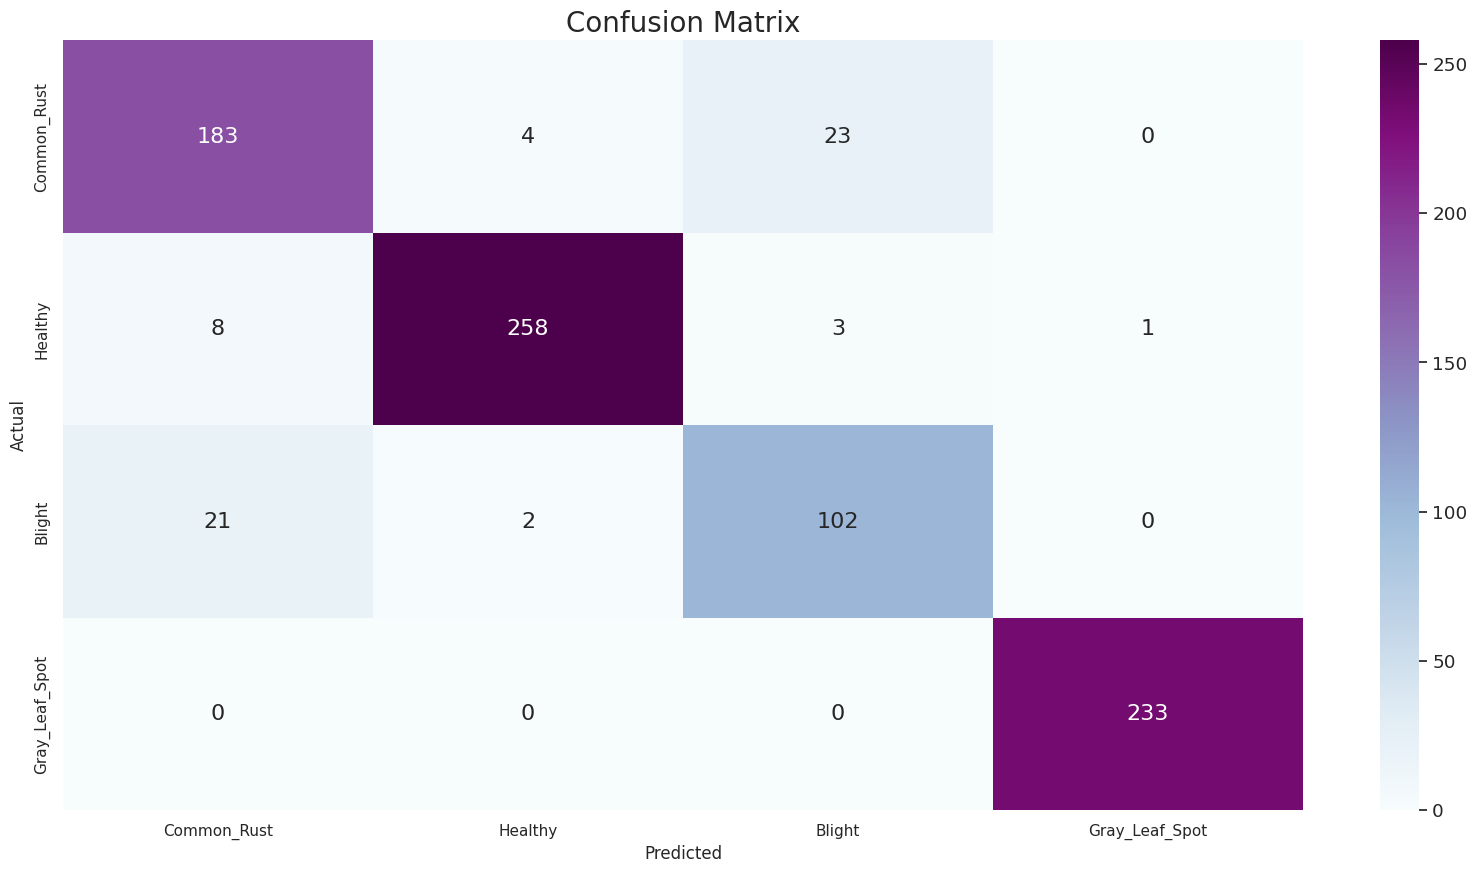

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import plotly.express as px

#Plotting the confusion matrix using test_images.class as the actual labels and y_preds as Predicted ones
classes=image_df['Label'].unique()

cm_data = confusion_matrix(test_images.classes , y_preds)
cm = pd.DataFrame(cm_data, columns=classes, index = classes)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=True, cmap="BuPu", annot=True, annot_kws={"size": 16}, fmt='g')